<a href="https://colab.research.google.com/github/edoadro/master_thesis/blob/EDA_Seb/benchmark_models" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# train baseline models v2 (with per-keyword metrics)
- we split up for testing horizon 1 week 6 week and 12 weeks
- we train the models univariate, on a subset of variables native to the original data and similarity data included
- **v2 enhancements**: Evaluates all models per keyword (per time series) and exports average/median RMSE/SMAPE across keywords to CSV files

In [ ]:
# ==================== CELL 1: Setup & Config ====================

!pip -q install pandas numpy scikit-learn xgboost lightgbm torch torchvision torchaudio statsmodels seaborn pyarrow tqdm

# Then, mount Google Drive with force_remount=True
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
from pathlib import Path
import numpy as np
import torch

# --------- Paths ---------
BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/master_thesis_gdrive")
PANEL_PATH = BASE_DIR / "sebs_weekly_aggregated_by_week_keyword.parquet"  # <- your file
RESULTS_DIR = BASE_DIR / "model_results_horizons"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# --------- Column names ---------
ID_COL     = "keyword"   # time series id
TIME_COL   = "ds"        # we'll derive from 'week'
TARGET_COL = "cpc_week"  # target to forecast

# --------- Horizons ---------
HORIZONS = [1, 6, 12]    # 1-week, 6-week, 12-week ahead

# --------- Split ---------
TEST_WEEKS = 12          # <--- NEW: Last 12 weeks for final testing
VAL_FRACTION = 0.2       # Fraction of the REMAINING data for validation

# --------- Device / seeds ---------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using DEVICE = {DEVICE}")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)


Mounted at /content/drive
Using DEVICE = cuda


In [ ]:
# ==================== CELL 2: Helper Functions (ML, NN, SARIMAX per keyword) ====================

import re
from typing import Dict, List, Tuple
from dataclasses import dataclass

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --------- Globals (must match Cell 1) ---------
ID_COL     = "keyword"
TIME_COL   = "ds"
TARGET_COL = "cpc_week"
VAL_FRACTION = 0.2
HORIZONS   = [1, 6, 12]

# ---------- Metrics ----------

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom[denom == 0] = 1.0
    return 100.0 * np.mean(np.abs(y_pred - y_true) / denom)


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def safe_metrics(y_true, y_pred, label=""):
    """
    Drop NaN/inf from y_true or y_pred before computing metrics.
    Returns (rmse_val, smape_val, n_used, n_total).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    n_total = len(y_true)
    n_used = int(mask.sum())

    if n_used == 0:
        print(f"[safe_metrics] WARNING: no finite values for {label}; metrics set to NaN.")
        return np.nan, np.nan, n_used, n_total

    if n_used < n_total:
        print(f"[safe_metrics] Dropped {n_total - n_used} / {n_total} points for {label} due to NaN/inf.")

    return rmse(y_true[mask], y_pred[mask]), smape(y_true[mask], y_pred[mask]), n_used, n_total

# ---------- Week -> date ----------

def iso_week_to_date(ww_yyyy: str):
    """
    Convert 'WW-YYYY' (ISO week) to the Monday date of that week.
    """
    from datetime import date
    if ww_yyyy is None:
        return None
    s = str(ww_yyyy)
    m = re.fullmatch(r"(?P<w>\d{1,2})-(?P<y>\d{4})", s)
    if not m:
        return None
    w = int(m["w"])
    y = int(m["y"])
    return date.fromisocalendar(y, w, 1)  # Monday

# ---------- Data loading & horizon prep ----------

from pathlib import Path

def load_panel(path: str | Path) -> pd.DataFrame:
    """
    Load parquet panel, convert 'week' to ds, sort, and DROP adclicks_sum/adcost_sum.
    """
    path = str(path)
    df = pd.read_parquet(path)
    df["ds"] = df["week"].astype(str).apply(iso_week_to_date)
    df = df.dropna(subset=["ds"])
    df["ds"] = pd.to_datetime(df["ds"])
    df = df.sort_values([ID_COL, TIME_COL]).reset_index(drop=True)

    # Drop strong-leakage columns globally as requested
    for col in ["adclicks_sum", "adcost_sum"]:
        if col in df.columns:
            df = df.drop(columns=col)

    return df

def build_horizon_dataset(panel: pd.DataFrame, horizon: int) -> Tuple[pd.DataFrame, str]:
    """
    For each keyword, create y_{t+h} as future target.
    """
    df = panel.copy()
    target_col = f"y_h{horizon}"
    df[target_col] = df.groupby(ID_COL)[TARGET_COL].shift(-horizon)
    df = df.dropna(subset=[target_col]).reset_index(drop=True)
    return df, target_col

def time_based_train_val_test_split(df, test_weeks=12, val_fraction=0.2):
    """
    Splits data into Train, Validation, and Test.
    1. Test = Last `test_weeks` (e.g., 12).
    2. Val  = Last `val_fraction` (e.g., 20%) of the remaining data.
    3. Train = The rest.
    """
    unique_weeks = np.sort(df[TIME_COL].unique())

    # 1. Separate Test Set
    if len(unique_weeks) <= test_weeks:
        raise ValueError("Not enough data to create a test set.")

    test_start_date = unique_weeks[-test_weeks]
    test_df = df[df[TIME_COL] >= test_start_date].copy()
    remaining_df = df[df[TIME_COL] < test_start_date].copy()

    # 2. Separate Validation from the Remaining (Train + Val)
    unique_rem_weeks = np.sort(remaining_df[TIME_COL].unique())
    cutoff_idx = int(len(unique_rem_weeks) * (1.0 - val_fraction))
    cutoff_idx = max(1, min(cutoff_idx, len(unique_rem_weeks) - 1))
    val_start_date = unique_rem_weeks[cutoff_idx]

    train_df = remaining_df[remaining_df[TIME_COL] <= val_start_date].copy()
    val_df   = remaining_df[remaining_df[TIME_COL] >  val_start_date].copy()

    return train_df, val_df, test_df

# ---------- Feature selection for ML/NN ----------

def get_feature_cols(df: pd.DataFrame, target_col: str, mode: str) -> List[str]:
    """
    mode:
      - 'cpc_only'   : only current cpc_week
      - 'exog_small' : cpc_week + selected exogs
      - 'exog_all'   : all numeric exogs except adclicks_sum & adcost_sum
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # remove horizon targets
    horizon_targets = [c for c in num_cols if c.startswith("y_h")]
    for c in horizon_targets:
        if c in num_cols:
            num_cols.remove(c)

    # small-exog set
    exog_small = [
        "impressions_sum",
        "n_dev_desktop",
        "n_dev_mobile",
        "n_dev_tablet",
        "n_st_branded_search",
        "n_st_generic_search",
    ]

    # exogs to drop from exog_all (also dropped globally, but keep for safety)
    strong_corr = ["adclicks_sum", "adcost_sum"]

    if mode == "cpc_only":
        feat_cols = [TARGET_COL]

    elif mode == "exog_small":
        feat_cols = [TARGET_COL] + [c for c in exog_small if c in df.columns]

    elif mode == "exog_all":
        exclude = {ID_COL, TIME_COL, target_col, TARGET_COL} | set(strong_corr)
        feat_cols = [
            c for c in df.columns
            if (c not in exclude)
            and (c in num_cols)
        ]
        # we still want TARGET_COL included
        if TARGET_COL in num_cols and TARGET_COL not in feat_cols:
            feat_cols.append(TARGET_COL)
    else:
        raise ValueError(f"Unknown mode: {mode}")

    feat_cols = [c for c in feat_cols if c in num_cols]
    feat_cols = sorted(set(feat_cols))
    if not feat_cols:
        raise ValueError(f"No numeric features found for mode={mode}")
    return feat_cols

# ---------- Exogenous columns for SARIMAX ----------

def get_sarimax_exog_cols(df: pd.DataFrame, mode: str) -> List[str]:
    """
    Exogenous features for SARIMAX (per-keyword time series).
    - 'cpc_only'   : no exogenous -> pure ARIMA
    - 'exog_small' : small exog set (without TARGET_COL)
    - 'exog_all'   : all numeric exogs except TARGET_COL, adclicks_sum, adcost_sum, ID_COL, TIME_COL
    """
    if mode == "cpc_only":
        return []

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # small-exog set
    exog_small = [
        "impressions_sum",
        "n_dev_desktop",
        "n_dev_mobile",
        "n_dev_tablet",
        "n_st_branded_search",
        "n_st_generic_search",
    ]
    strong_corr = ["adclicks_sum", "adcost_sum"]

    if mode == "exog_small":
        return [c for c in exog_small if c in df.columns]

    elif mode == "exog_all":
        exclude = {ID_COL, TIME_COL, TARGET_COL} | set(strong_corr)
        return sorted(
            c for c in df.columns
            if (c not in exclude) and (c in num_cols)
        )
    else:
        raise ValueError(f"Unknown SARIMAX exog mode: {mode}")

# ---------- Optional: reindex & impute ----------

def reindex_and_impute(panel: pd.DataFrame) -> pd.DataFrame:
    """
    For each keyword, reindex to full date range [min(ds), max(ds)] with weekly freq
    and linearly interpolate numeric columns.
    """
    panel = panel.copy()
    numeric_cols = panel.select_dtypes(include=[np.number]).columns.tolist()

    all_dates = pd.date_range(panel["ds"].min(), panel["ds"].max(), freq="W-MON")

    def _impute_group(g):
        g = g.set_index("ds").reindex(all_dates)
        # fill id
        g[ID_COL] = g[ID_COL].ffill().bfill().iloc[0]
        # interpolate numeric
        for c in numeric_cols:
            g[c] = g[c].interpolate(method="linear", limit_direction="both")
        g = g.reset_index().rename(columns={"index": "ds"})
        return g

    out = (
        panel.groupby(ID_COL, group_keys=False)
              .apply(_impute_group)
              .sort_values([ID_COL, "ds"])
              .reset_index(drop=True)
    )
    return out

# ---------- Scaling & matrices for ML/NN ----------

@dataclass
class DataMatrices:
    X_train: np.ndarray
    y_train: np.ndarray
    X_val:   np.ndarray
    y_val:   np.ndarray
    X_test:  np.ndarray  # <--- Added
    y_test:  np.ndarray  # <--- Added
    scaler:  StandardScaler
    feature_cols: List[str]

def build_matrices(train, val, test, target_col, mode):
    feat_cols = get_feature_cols(train, target_col, mode)

    scaler = StandardScaler()
    # Fit ONLY on training data
    X_train = scaler.fit_transform(train[feat_cols].values)
    # Transform Val and Test using Train statistics
    X_val   = scaler.transform(val[feat_cols].values)
    X_test  = scaler.transform(test[feat_cols].values)

    y_train = train[target_col].values.astype(np.float32)
    y_val   = val[target_col].values.astype(np.float32)
    y_test  = test[target_col].values.astype(np.float32)

    return DataMatrices(
        X_train=X_train, y_train=y_train,
        X_val=X_val,     y_val=y_val,
        X_test=X_test,   y_test=y_test,
        scaler=scaler,
        feature_cols=feat_cols,
    )

# ---------- ML models (RF, XGB, LGBM) ----------

def get_ml_models() -> Dict[str, object]:
    models = {
        "ml | RF": RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            n_jobs=-1,
            random_state=42
        ),
        "ml | XGB": XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            random_state=42
        ),
        "ml | LGBM": LGBMRegressor(
            n_estimators=400,
            learning_rate=0.05,
            num_leaves=64,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
        )
    }
    return models

def train_ml_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# ---------- Torch dataset & models (NN) ----------

class TabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLPRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dims=(128, 64)):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 64, num_layers: int = 1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, input_dim) -> (batch, seq=1, input_dim)
        x_seq = x.unsqueeze(1)
        out, (h_n, c_n) = self.lstm(x_seq)
        h_last = h_n[-1]
        return self.fc(h_last).squeeze(-1)

class GRURegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 64, num_layers: int = 1):
        super().__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True)
        self.fc  = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x_seq = x.unsqueeze(1)
        out, h_n = self.gru(x_seq)
        h_last = h_n[-1]
        return self.fc(h_last).squeeze(-1)

def train_torch_model(
    model: nn.Module,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    n_epochs: int = 20,
    batch_size: int = 256,
    lr: float = 1e-3,
    device: str = "cuda",
    max_grad_norm: float = 5.0,
) -> Tuple[nn.Module, np.ndarray]:
    """
    Train a PyTorch regressor with:
      - gradient clipping (max_grad_norm)
      - NaN/inf loss guard (early break)
      - best-val checkpointing
    """
    model = model.to(device)
    train_ds = TabularDataset(X_train, y_train)
    val_ds   = TabularDataset(X_val,   y_val)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val = float("inf")
    best_state = None

    for epoch in range(1, n_epochs + 1):
        model.train()
        broke_for_nan = False

        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()

            preds = model(xb)
            loss = criterion(preds, yb)

            # NaN / inf guard
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"[train_torch_model] NaN/inf loss at epoch {epoch}, "
                      f"stopping training for this model.")
                broke_for_nan = True
                break

            loss.backward()

            # Gradient clipping to avoid exploding gradients
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

        if broke_for_nan:
            break

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()

    # Restore best state if we ever found one
    if best_state is not None:
        model.load_state_dict(best_state)

    # Final validation predictions
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
    preds = np.concatenate(preds, axis=0)

    return model, preds



In [ ]:
# ==================== CELL 2b: Per-Keyword Evaluation Function (v2 feature) ====================

def evaluate_model_per_keyword(
    model,
    val_df: pd.DataFrame,
    target_col: str,
    scaler: StandardScaler,
    feature_cols: List[str],
    device: str = "cpu"
) -> pd.DataFrame:
    """
    Evaluate a trained model separately on each keyword's validation data.
    Returns DataFrame with columns: keyword, rmse, smape, n_points
    """
    results = []

    for kw, g in val_df.groupby(ID_COL):
        if len(g) == 0:
            continue

        X_kw = scaler.transform(g[feature_cols].values)
        y_kw = g[target_col].values

        # Predict based on model type
        if isinstance(model, nn.Module):
            model.eval()
            with torch.no_grad():
                X_tensor = torch.tensor(X_kw, dtype=torch.float32).to(device)
                y_pred = model(X_tensor).cpu().numpy()
        elif isinstance(model, LGBMRegressor):
            X_kw_df = pd.DataFrame(X_kw, columns=feature_cols)
            y_pred = model.predict(X_kw_df)
        else:
             y_pred = model.predict(X_kw)

        # Compute metrics
        mask = np.isfinite(y_kw) & np.isfinite(y_pred)
        if mask.sum() == 0:
            continue

        y_kw_m = y_kw[mask]
        y_pred_m = y_pred[mask]

        results.append({
            'keyword': kw,
            'rmse': rmse(y_kw_m, y_pred_m),
            'smape': smape(y_kw_m, y_pred_m),
            'n_points': int(mask.sum())
        })

    return pd.DataFrame(results)

Using DEVICE = cuda
NaN counts after imputation:
avg_sim_top25_last_week    0
dtype: int64
Loaded panel: 218,924 rows, 1,811 keywords.

===== Horizon h=1 =====
Train: 156917, Val: 38908, Test: 21288

--- Mode: cpc_only ---
Training ML: ml | RF | cpc_only (h=1)
  -> Evaluated on 1810 keywords
Training ML: ml | XGB | cpc_only (h=1)
  -> Evaluated on 1810 keywords
Training ML: ml | LGBM | cpc_only (h=1)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 156917, number of used features: 1
[LightGBM] [Info] Start training from score 2.792653
  -> Evaluated on 1810 keywords
Training NN: nn | MLP | cpc_only (h=1) on cuda
  -> Evaluated on 1810 keywords
Training NN: nn | LSTM | cpc_only (h=1) on cuda
  -> Evaluated on 1810 keywords
Training NN: nn | GRU | cpc_only (h=1) on cuda
  -> Evaluated on

,model_id,horizon,exog_mode,avg_rmse,median_rmse,avg_smape,median_smape,n_keywords,total_points
45,nn | MLP,1,cpc_only,1.127,0.818,31.827,28.921,1810,21288
36,nn | LSTM,1,cpc_only,1.132,0.828,32.156,29.138,1810,21288
18,ml | XGB,1,cpc_only,1.138,0.835,32.182,29.096,1810,21288
0,ml | LGBM,1,cpc_only,1.138,0.833,32.185,29.226,1810,21288
27,nn | GRU,1,cpc_only,1.137,0.833,32.305,29.260,1810,21288
...,...,...,...,...,...,...,...,...,...
35,nn | GRU,12,exog_small,1.412,1.163,40.594,38.067,1810,20767
8,ml | LGBM,12,exog_small,1.453,1.265,40.895,38.601,1810,20767
26,ml | XGB,12,exog_small,1.449,1.249,40.905,38.611,1810,20767
17,ml | RF,12,exog_small,1.588,1.381,43.018,40.514,1810,20767



=== Aggregated Results by Model & Horizon (across exog_modes) ===


,model_id,horizon,avg_rmse,median_rmse,avg_smape,median_smape,n_keywords
12,nn | LSTM,1,1.117,0.840,31.397,28.176,1810
6,ml | XGB,1,1.123,0.864,31.422,28.258,1810
0,ml | LGBM,1,1.127,0.868,31.535,28.308,1810
15,nn | MLP,1,1.127,0.877,31.820,28.766,1810
9,nn | GRU,1,1.128,0.859,31.859,28.558,1810
3,ml | RF,1,1.245,0.997,33.776,30.755,1810
18,stats | SARIMAX_kw,1,1.649,1.194,43.095,37.791,1811
7,ml | XGB,6,1.328,1.095,37.713,34.665,1810
10,nn | GRU,6,1.318,1.064,37.736,34.636,1810
13,nn | LSTM,6,1.319,1.079,37.847,34.635,1810



=== Best Model per Horizon (by avg sMAPE) ===


,horizon,model_id,avg_rmse,median_rmse,avg_smape,median_smape,n_keywords
0,1,nn | LSTM,1.117,0.840,31.397,28.176,1810
1,6,ml | XGB,1.328,1.095,37.713,34.665,1810
2,12,nn | MLP,1.472,1.265,42.201,39.514,1810



=== Average sMAPE by model/exog_mode & horizon ===


horizon                            1       6       12
model_id           exog_mode                         
ml | LGBM          cpc_only    32.185  38.014  42.168
                   exog_all    31.740  39.011  44.567
                   exog_small  30.680  36.616  40.895
ml | RF            cpc_only    37.718  43.685  47.980
                   exog_all    31.528  38.409  44.725
                   exog_small  32.081  38.249  43.018
ml | XGB           cpc_only    32.182  38.018  42.168
                   exog_all    31.369  38.478  44.179
                   exog_small  30.714  36.642  40.905
nn | GRU           cpc_only    32.305  38.221  41.819
                   exog_all    32.276  38.541  44.376
                   exog_small  30.996  36.447  40.594
nn | LSTM          cpc_only    32.156  38.067  42.447
                   exog_all    31.340  38.852  45.468
                   exog_small  30.696  36.622  40.393
nn | MLP           cpc_only    31.827  37.230  42.192
                   exog_all    33.214  40.042  44.184
                   exog_small  30.420  38.104  40.227
stats | SARIMAX_kw cpc_only    40.308  40.904  41.990
                   exog_all    45.240  45.175  45.491
                   exog_small  43.737  43.935  44.296


=== Average RMSE by model/exog_mode & horizon ===


horizon                           1      6      12
model_id           exog_mode                      
ml | LGBM          cpc_only    1.138  1.331  1.466
                   exog_all    1.134  1.373  1.530
                   exog_small  1.109  1.302  1.453
ml | RF            cpc_only    1.424  1.695  1.898
                   exog_all    1.140  1.378  1.584
                   exog_small  1.171  1.397  1.588
ml | XGB           cpc_only    1.138  1.331  1.466
                   exog_all    1.124  1.351  1.519
                   exog_small  1.108  1.301  1.449
nn | GRU           cpc_only    1.137  1.328  1.443
                   exog_all    1.135  1.342  1.480
                   exog_small  1.113  1.283  1.412
nn | LSTM          cpc_only    1.132  1.336  1.467
                   exog_all    1.110  1.329  1.525
                   exog_small  1.108  1.292  1.409
nn | MLP           cpc_only    1.127  1.298  1.490
                   exog_all    1.164  1.392  1.485
                   exog_small  1.090  1.339  1.440
stats | SARIMAX_kw cpc_only    1.495  1.493  1.496
                   exog_all    1.753  1.695  1.644
                   exog_small  1.699  1.660  1.613

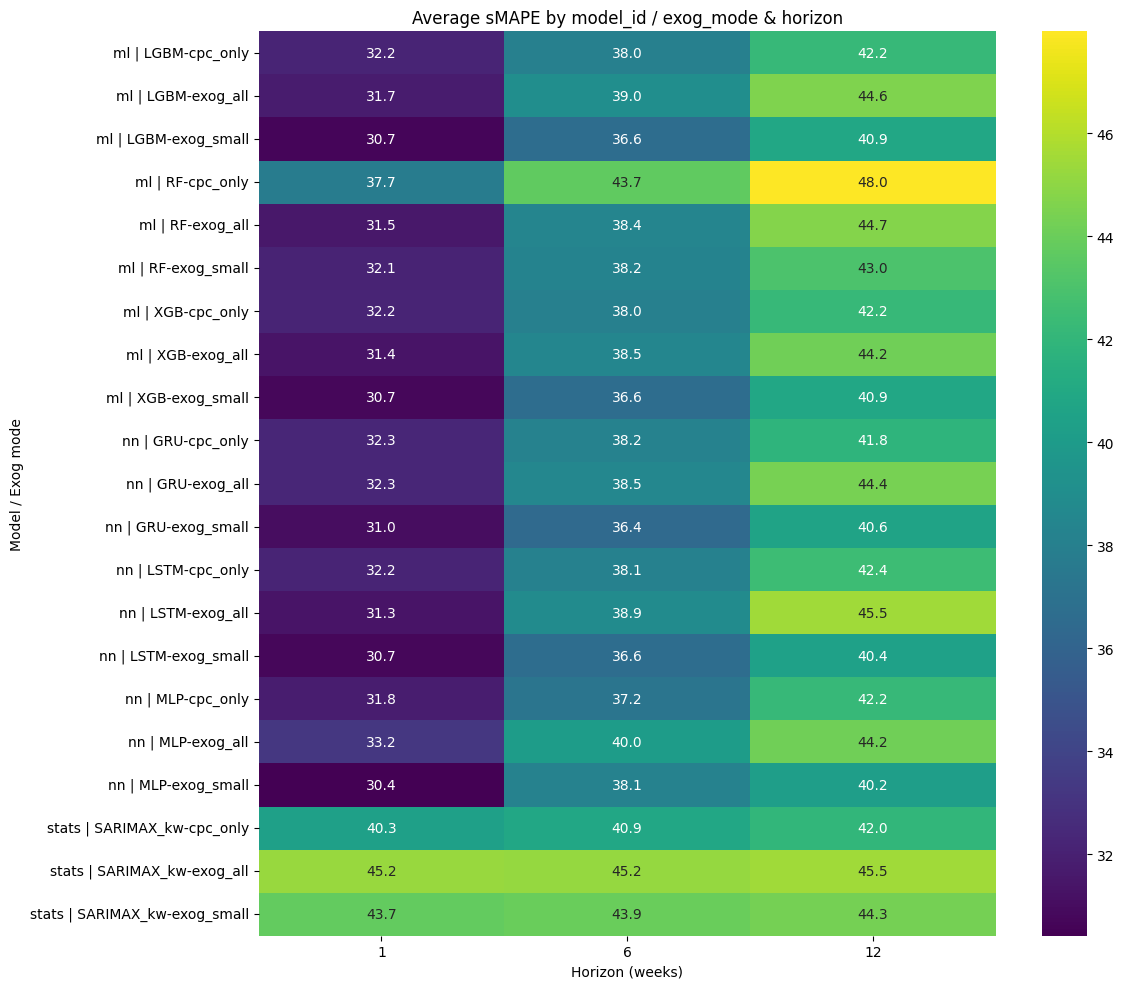

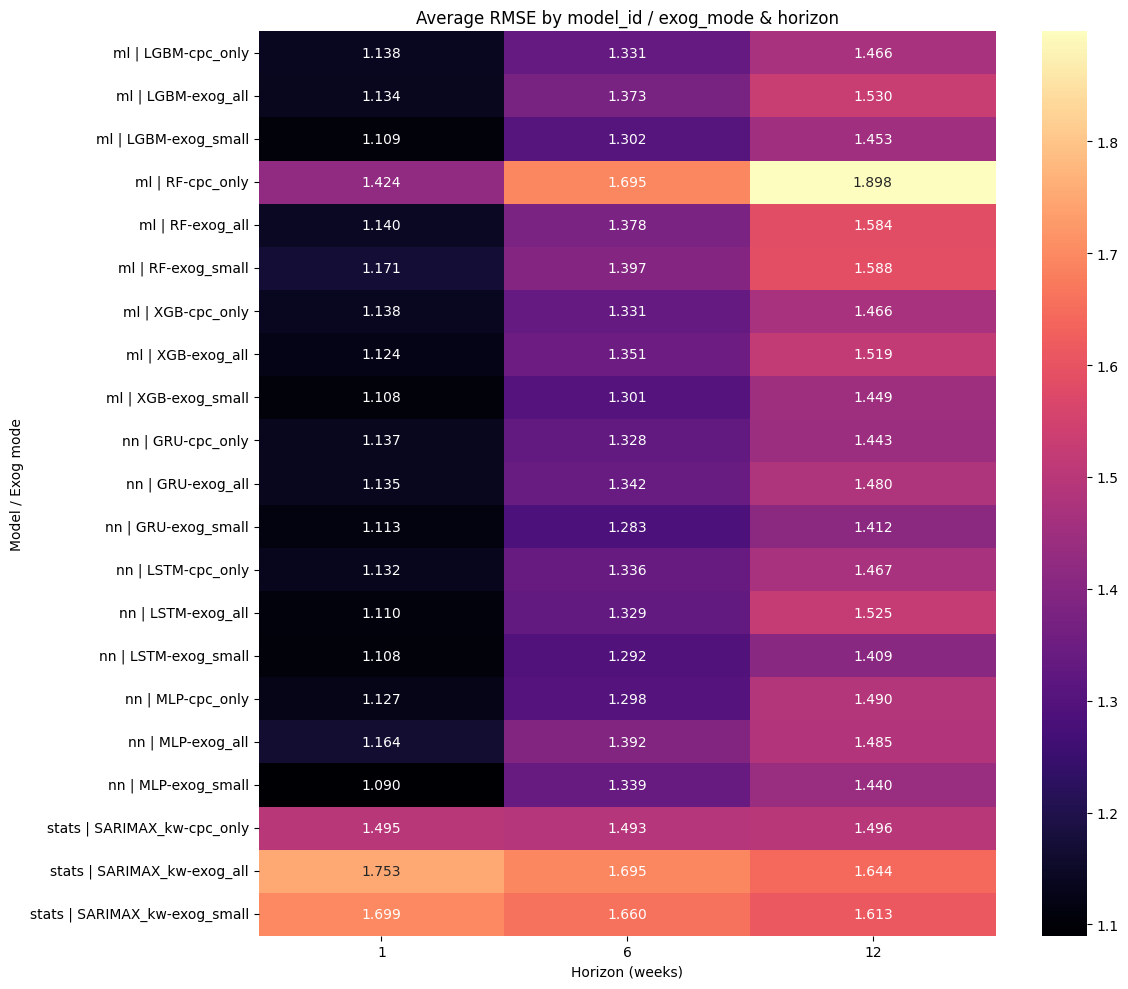

In [ ]:
# ==================== CELL 3: Train ML + NN + SARIMAX & Evaluate (v2: per-keyword metrics) ====================

import copy, warnings
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# --- Paths (must match Cell 1) ---
BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/master_thesis_gdrive")
PANEL_PATH = BASE_DIR / "sebs_weekly_aggregated_by_week_keyword.parquet"  # <- your file
RESULTS_DIR = BASE_DIR / "model_results_horizons"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using DEVICE = {DEVICE}")

# v2: Store per-keyword results
ml_nn_per_keyword_results = []

# 1) Load panel
panel = load_panel(PANEL_PATH)
panel = panel.sort_values([ID_COL, TIME_COL])

# Impute missing lag features
lag_columns = ["avg_sim_top25_last_week"]
panel[lag_columns] = (
    panel.groupby(ID_COL)[lag_columns]
         .apply(lambda g: g.ffill().bfill())
         .reset_index(level=0, drop=True)
)

print("NaN counts after imputation:")
print(panel[lag_columns].isna().sum())
print(f"Loaded panel: {panel.shape[0]:,} rows, {panel[ID_COL].nunique():,} keywords.")

# 2) ML + NN models for each horizon & exog mode
ml_templates = get_ml_models()

for h in HORIZONS:
    print(f"\n===== Horizon h={h} =====")
    df_h, target_col = build_horizon_dataset(panel, horizon=h)

    # NEW: 3-way split
    train_df, val_df, test_df = time_based_train_val_test_split(
        df_h, test_weeks=TEST_WEEKS, val_fraction=VAL_FRACTION
    )
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    for mode in ["cpc_only", "exog_small", "exog_all"]:
        print(f"\n--- Mode: {mode} ---")
        try:
            mats = build_matrices(train_df, val_df, test_df, target_col, mode)
        except ValueError as e:
            print(f"Skipping mode={mode} for h={h}: {e}")
            continue

        X_train, y_train = mats.X_train, mats.y_train
        X_val,   y_val   = mats.X_val,   mats.y_val
        input_dim = X_train.shape[1]

        # ---- ML models ----
        for base_name, base_model in ml_templates.items():
            model = copy.deepcopy(base_model)
            model_name = f"{base_name} | {mode}"
            print(f"Training ML: {model_name} (h={h})")
            model = train_ml_model(model, X_train, y_train)

            # v2: Evaluate per keyword
            per_kw_df = evaluate_model_per_keyword(
                model, test_df, target_col, mats.scaler, mats.feature_cols, device=DEVICE
            )
            per_kw_df['horizon'] = h
            per_kw_df['model_id'] = base_name
            per_kw_df['exog_mode'] = mode
            ml_nn_per_keyword_results.append(per_kw_df)
            print(f"  -> Evaluated on {len(per_kw_df)} keywords")

        # ---- NN models ----
        nn_configs = [
            ("nn | MLP",  lambda: MLPRegressor(input_dim=input_dim, hidden_dims=(128,64))),
            ("nn | LSTM", lambda: LSTMRegressor(input_dim=input_dim, hidden_dim=64, num_layers=1)),
            ("nn | GRU",  lambda: GRURegressor(input_dim=input_dim, hidden_dim=64, num_layers=1)),
        ]

        for base_name, builder in nn_configs:
            model_name = f"{base_name} | {mode}"
            print(f"Training NN: {model_name} (h={h}) on {DEVICE}")
            nn_model = builder()
            nn_model, _ = train_torch_model(
                nn_model,
                X_train, y_train,
                X_val,   y_val,
                n_epochs=20,
                batch_size=256,
                lr=1e-3,
                device=DEVICE,
                max_grad_norm=5.0,
            )

            # v2: Evaluate per keyword
            per_kw_df = evaluate_model_per_keyword(
                nn_model, test_df, target_col, mats.scaler, mats.feature_cols, device=DEVICE
            )
            per_kw_df['horizon'] = h
            per_kw_df['model_id'] = base_name
            per_kw_df['exog_mode'] = mode
            ml_nn_per_keyword_results.append(per_kw_df)
            print(f"  -> Evaluated on {len(per_kw_df)} keywords")

# Concatenate all ML/NN per-keyword results
ml_nn_per_kw_df = pd.concat(ml_nn_per_keyword_results, ignore_index=True)
print(f"\n✅ ML/NN per-keyword results: {len(ml_nn_per_kw_df)} rows")

# 3) SARIMAX(1,1,0) per keyword with 3 exog modes
print("\n===== SARIMAX(1,1,0) per keyword (per-key split, 3 exog modes) =====")

sarimax_kw_metrics = []
min_total_len = 30
max_h = max(HORIZONS)

for mode in ["cpc_only", "exog_small", "exog_all"]:
    exog_cols = get_sarimax_exog_cols(panel, mode)
    print(f"\n--- SARIMAX mode={mode}, exog_cols={exog_cols} ---")

    for kw, g in panel.groupby(ID_COL):
        g = g.sort_values(TIME_COL).copy()

        if not np.isfinite(g[TARGET_COL].astype(float)).any():
            continue

        if exog_cols:
            g = g.dropna(subset=exog_cols + [TARGET_COL])
        else:
            g = g.dropna(subset=[TARGET_COL])

        n = len(g)
        if n < min_total_len:
            continue

        split_idx = int(n * (1.0 - VAL_FRACTION))
        split_idx = max(1, min(split_idx, n - 1))

        g_train = g.iloc[:split_idx].copy()
        g_val   = g.iloc[split_idx:].copy()

        if len(g_val) <= max_h:
            continue

        y_train = g_train[TARGET_COL].astype(float).values
        y_val   = g_val[TARGET_COL].astype(float).values

        if not np.isfinite(y_train).any():
            continue

        if exog_cols:
            exog_train = g_train[exog_cols].astype(float).values
            exog_val   = g_val[exog_cols].astype(float).values
        else:
            exog_train = None
            exog_val   = None

        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = SARIMAX(
                    y_train,
                    exog=exog_train,
                    order=(1, 1, 0),
                    seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                res = model.fit(disp=False)
                fc  = res.get_forecast(steps=len(y_val), exog=exog_val)

                pm = fc.predicted_mean
                if hasattr(pm, "to_numpy"):
                    y_pred_all = pm.to_numpy()
                else:
                    y_pred_all = np.asarray(pm)
        except Exception:
            continue

        for h in HORIZONS:
            if len(y_val) <= h:
                continue

            y_true = y_val[h:]
            y_pred = y_pred_all[:-h]
            mask = np.isfinite(y_true) & np.isfinite(y_pred)
            if mask.sum() == 0:
                continue

            y_true_m = y_true[mask]
            y_pred_m = y_pred[mask]

            sarimax_kw_metrics.append({
                "keyword":   kw,
                "exog_mode": mode,
                "horizon":   h,
                "rmse":      rmse(y_true_m, y_pred_m),
                "smape":     smape(y_true_m, y_pred_m),
                "n_points":  int(mask.sum())
            })

sarimax_metrics_df = pd.DataFrame(sarimax_kw_metrics)
sarimax_metrics_df['model_id'] = 'stats | SARIMAX_kw'
print(f"\n✅ SARIMAX per-keyword results: {len(sarimax_metrics_df)} rows")

# 4) Combine all per-keyword results
all_per_keyword_df = pd.concat([
    ml_nn_per_kw_df,
    sarimax_metrics_df[['keyword', 'model_id', 'horizon', 'exog_mode', 'rmse', 'smape', 'n_points']]
], ignore_index=True)

print(f"\n✅ Combined per-keyword results: {len(all_per_keyword_df)} rows")

# 5) Aggregate across keywords
print("\n===== Aggregating metrics across keywords =====")

# Aggregate by (model_id, horizon, exog_mode)
all_models_aggregated = (
    all_per_keyword_df
    .groupby(['model_id', 'horizon', 'exog_mode'], as_index=False)
    .agg(
        avg_rmse=('rmse', 'mean'),
        median_rmse=('rmse', 'median'),
        avg_smape=('smape', 'mean'),
        median_smape=('smape', 'median'),
        n_keywords=('keyword', 'nunique'),
        total_points=('n_points', 'sum')
    )
    .sort_values(['horizon', 'exog_mode', 'avg_smape'])
)

# Aggregate by (model_id, horizon) - across exog_modes
all_models_by_horizon = (
    all_per_keyword_df
    .groupby(['model_id', 'horizon'], as_index=False)
    .agg(
        avg_rmse=('rmse', 'mean'),
        median_rmse=('rmse', 'median'),
        avg_smape=('smape', 'mean'),
        median_smape=('smape', 'median'),
        n_keywords=('keyword', 'nunique')
    )
    .sort_values(['horizon', 'avg_smape'])
)

# Best model per horizon
best_per_horizon = (
    all_models_by_horizon
    .sort_values('avg_smape')
    .groupby('horizon')
    .first()
    .reset_index()
)

# 6) Save all CSVs
print("\n===== Saving results to CSV =====")

all_per_kw_path = RESULTS_DIR / "all_models_per_keyword_metrics.csv"
agg_detailed_path = RESULTS_DIR / "aggregated_by_model_horizon_exog.csv"
agg_summary_path = RESULTS_DIR / "aggregated_by_model_horizon.csv"
best_path = RESULTS_DIR / "best_models_per_horizon.csv"
sarimax_path = RESULTS_DIR / "sarimax_per_keyword_metrics_full.csv"

all_per_keyword_df.to_csv(all_per_kw_path, index=False)
all_models_aggregated.to_csv(agg_detailed_path, index=False)
all_models_by_horizon.to_csv(agg_summary_path, index=False)
best_per_horizon.to_csv(best_path, index=False)
sarimax_metrics_df.to_csv(sarimax_path, index=False)

print(f"\n✅ Saved 5 CSV files:")
print(f"   1. {all_per_kw_path}")
print(f"   2. {agg_detailed_path}")
print(f"   3. {agg_summary_path}")
print(f"   4. {best_path}")
print(f"   5. {sarimax_path}")

# 7) Display results
print("\n=== Aggregated Results by Model, Horizon & Exog Mode ===")
display(all_models_aggregated.round(3))

print("\n=== Aggregated Results by Model & Horizon (across exog_modes) ===")
display(all_models_by_horizon.round(3))

print("\n=== Best Model per Horizon (by avg sMAPE) ===")
display(best_per_horizon.round(3))

# 8) Pivot tables and heatmaps
pivot_rmse = all_models_aggregated.pivot_table(
    index=["model_id", "exog_mode"],
    columns="horizon",
    values="avg_rmse",
    aggfunc="mean"
)
pivot_smape = all_models_aggregated.pivot_table(
    index=["model_id", "exog_mode"],
    columns="horizon",
    values="avg_smape",
    aggfunc="mean"
)

print("\n=== Average sMAPE by model/exog_mode & horizon ===")
display(pivot_smape.round(3))

print("\n=== Average RMSE by model/exog_mode & horizon ===")
display(pivot_rmse.round(3))

# Heatmaps
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_smape, annot=True, fmt=".1f", cmap="viridis")
plt.title("Average sMAPE by model_id / exog_mode & horizon")
plt.xlabel("Horizon (weeks)")
plt.ylabel("Model / Exog mode")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_rmse, annot=True, fmt=".3f", cmap="magma")
plt.title("Average RMSE by model_id / exog_mode & horizon")
plt.xlabel("Horizon (weeks)")
plt.ylabel("Model / Exog mode")
plt.tight_layout()
plt.show()


## TabPFN-TS (zero-shot) baseline

This section adds a **zero-shot** forecasting baseline using `tabpfn-time-series` (no training loop). It evaluates on the same test window logic used above (last `TEST_WEEKS`), aligning predictions to the `y_h{h}` shifted targets.


In [ ]:
# ==================== CELL 5: TabPFN-TS zero-shot baseline (no training) ====================

!pip -q install tabpfn-time-series tabpfn datasets

import pandas as pd
import numpy as np
from pathlib import Path
import torch

from tabpfn_time_series import TimeSeriesDataFrame, FeatureTransformer, TabPFNTimeSeriesPredictor, TabPFNMode
from tabpfn_time_series.data_preparation import generate_test_X
from tabpfn_time_series.features import RunningIndexFeature, CalendarFeature, AutoSeasonalFeature

from pandas.tseries.frequencies import to_offset

# --- Paths (must match Cell 1) ---
BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/master_thesis_gdrive")
PANEL_PATH = BASE_DIR / "sebs_weekly_aggregated_by_week_keyword.parquet"
RESULTS_DIR = BASE_DIR / "model_results_horizons"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using DEVICE = {DEVICE}")

# ---------------- Helpers ----------------

def _pick_point_forecast_col(pred_df: pd.DataFrame) -> str:
    for c in ["mean", "0.5", "median", "p50"]:
        if c in pred_df.columns:
            return c
    num_cols = [c for c in pred_df.columns if pd.api.types.is_numeric_dtype(pred_df[c])]
    return num_cols[0] if num_cols else pred_df.columns[-1]

def panel_to_tsdf(panel_df: pd.DataFrame, target: str, exog_cols=None) -> TimeSeriesDataFrame:
    exog_cols = exog_cols or []
    df = panel_df[[ID_COL, TIME_COL, target] + exog_cols].copy()
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df = df.sort_values([ID_COL, TIME_COL])
    df = df.rename(columns={ID_COL: "item_id", TIME_COL: "timestamp", target: "target"})
    df = df.set_index(["item_id", "timestamp"]).sort_index()
    return TimeSeriesDataFrame(df)

def tsdf_add_known_future_exog(test_tsdf: TimeSeriesDataFrame, future_panel: pd.DataFrame, exog_cols) -> TimeSeriesDataFrame:
    if not exog_cols:
        return test_tsdf
    fut = future_panel[[ID_COL, TIME_COL] + exog_cols].copy()
    fut[TIME_COL] = pd.to_datetime(fut[TIME_COL])
    fut = fut.rename(columns={ID_COL: "item_id", TIME_COL: "timestamp"})
    fut = fut.set_index(["item_id", "timestamp"]).sort_index()
    joined = test_tsdf.join(fut, how="left")
    return TimeSeriesDataFrame(joined)

def infer_panel_freq(panel_df: pd.DataFrame) -> str:
    ts = pd.to_datetime(panel_df[TIME_COL]).sort_values().dropna().unique()
    freq = pd.infer_freq(ts)
    return freq or "W-MON"

def add_h_steps(t: pd.Series, h: int, freq: str) -> pd.Series:
    off = to_offset(freq)
    return pd.to_datetime(t) + h * off

def force_tsdf_frequency_weekly(tsdf: TimeSeriesDataFrame, freq: str) -> TimeSeriesDataFrame:
    """
    CRITICAL FIX:
    Your debug showed predictions at DAILY timestamps (freq='D'), which makes the merge impossible.
    We force a regular weekly index with the correct anchor (W-MON for your data).
    """
    # Try AutoGluon-like API first (tabpfn_time_series TSDF is typically compatible)
    if hasattr(tsdf, "to_regular_index"):
        try:
            return tsdf.to_regular_index(freq=freq)
        except TypeError:
            # some versions accept DateOffset / string slightly differently
            return tsdf.to_regular_index(freq=str(freq))
    if hasattr(tsdf, "convert_frequency"):
        return tsdf.convert_frequency(freq=freq)
    # Fallback: leave unchanged (but warn)
    print("⚠️ Could not force frequency on TimeSeriesDataFrame (no to_regular_index/convert_frequency).")
    return tsdf

def debug_alignment(pred_df: pd.DataFrame, align: pd.DataFrame, freq: str):
    print("pred_df:", pred_df.shape, "unique items:", pred_df["item_id"].nunique())
    print("pred_df timestamp range:", pred_df["timestamp"].min(), "->", pred_df["timestamp"].max())
    print("align:", align.shape, "unique items:", align["item_id"].nunique())
    print("align timestamp range:", align["timestamp"].min(), "->", align["timestamp"].max())
    common_items = set(align["item_id"].unique()).intersection(set(pred_df["item_id"].unique()))
    print("common item_ids:", len(common_items))
    print("Inferred/forced freq:", freq)
    if common_items:
        sample_item = next(iter(common_items))
        a_ts = align.loc[align["item_id"] == sample_item, "timestamp"].head(10).tolist()
        p_ts = pred_df.loc[pred_df["item_id"] == sample_item, "timestamp"].head(10).tolist()
        print("sample_item:", sample_item)
        print("example align timestamps:", a_ts[:5])
        print("example pred  timestamps:", p_ts[:5])

def evaluate_tabpfn_ts(panel: pd.DataFrame, horizon: int, exog_mode: str, debug_if_empty: bool = True) -> pd.DataFrame:
    df_h, target_col_h = build_horizon_dataset(panel, horizon=horizon)
    train_df, val_df, test_df = time_based_train_val_test_split(df_h, test_weeks=TEST_WEEKS, val_fraction=VAL_FRACTION)

    test_start = pd.to_datetime(test_df[TIME_COL].min())
    pred_len = TEST_WEEKS + horizon

    history_panel = panel[pd.to_datetime(panel[TIME_COL]) < test_start].copy()

    hist_counts = history_panel.groupby(ID_COL).size()
    print("min history rows:", hist_counts.min(), "max:", hist_counts.max())
    print("items with 0 history rows in small set:",
          set(panel_small[ID_COL].unique()) - set(history_panel[ID_COL].unique()))
    if exog_mode == "univariate":
        exog_cols = []
    else:
        all_feats = get_feature_cols(panel, TARGET_COL, mode=exog_mode)
        exog_cols = [c for c in all_feats if c != TARGET_COL]

    # ---- Build TSDF and FORCE weekly frequency (CRITICAL FIX) ----
    freq = infer_panel_freq(panel)  # your debug said W-MON
    train_tsdf = panel_to_tsdf(history_panel, target=TARGET_COL, exog_cols=exog_cols)
    train_tsdf = force_tsdf_frequency_weekly(train_tsdf, freq=freq)

    test_tsdf  = generate_test_X(train_tsdf, prediction_length=pred_len)

    freq = "W-MON"  # since your panel infer showed W-MON
    train_tsdf = panel_to_tsdf(history_panel, target=TARGET_COL, exog_cols=exog_cols)

    # Make regular weekly grid + fill gaps
    train_tsdf = train_tsdf.convert_frequency(freq=freq)
    train_tsdf = train_tsdf.fill_missing_values(method="auto")

    if exog_cols:
        future_panel = panel[pd.to_datetime(panel[TIME_COL]) >= test_start].copy()
        test_tsdf = tsdf_add_known_future_exog(test_tsdf, future_panel, exog_cols)

    features = [RunningIndexFeature(), CalendarFeature(), AutoSeasonalFeature()]
    ft = FeatureTransformer(features)
    train_tsdf_f, test_tsdf_f = ft.transform(train_tsdf, test_tsdf)

    # extra numeric stability: float64 for numeric cols
    for name, tsdf in [("train", train_tsdf_f), ("test", test_tsdf_f)]:
        df_tmp = tsdf.copy()
        num_cols = [c for c in df_tmp.columns if pd.api.types.is_numeric_dtype(df_tmp[c])]
        df_tmp[num_cols] = df_tmp[num_cols].astype(np.float64)
        if name == "train":
            train_tsdf_f = TimeSeriesDataFrame(df_tmp)
        else:
            test_tsdf_f = TimeSeriesDataFrame(df_tmp)

    predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.LOCAL)
    pred = predictor.predict(train_tsdf_f, test_tsdf_f)

    pred_df = pred.reset_index()
    pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"])
    point_col = _pick_point_forecast_col(pred_df)
    pred_df = pred_df[["item_id", "timestamp", point_col]].rename(columns={point_col: "y_pred"})

    # ---- Align to y_{t+h} using the SAME weekly offset ----
    t_plus_h = add_h_steps(test_df[TIME_COL], horizon, freq)
    align = test_df[[ID_COL, TIME_COL, target_col_h]].copy()
    align["timestamp"] = pd.to_datetime(t_plus_h)
    align = align.rename(columns={ID_COL: "item_id", target_col_h: "y_true"})

    merged = align.merge(pred_df, on=["item_id", "timestamp"], how="left")
    merged = merged.dropna(subset=["y_pred"]).copy()

    if debug_if_empty and merged.empty:
        print("\n⚠️ No matched predictions after alignment/merge. Debug info:")
        debug_alignment(pred_df, align, freq=freq)

    out_rows = []
    for item_id, g in merged.groupby("item_id"):
        y_true = g["y_true"].astype(float).values
        y_pred = g["y_pred"].astype(float).values
        out_rows.append({
            "keyword": item_id,
            "rmse": float(np.sqrt(np.mean((y_true - y_pred) ** 2))),
            "smape": float(smape(y_true, y_pred)),
            "n_points": int(len(g)),
        })

    res = pd.DataFrame(out_rows)
    res["Horizon"] = horizon
    res["Model"] = "TabPFN-TS"
    res["exog_mode"] = exog_mode

    if len(merged) > 0:
        res.attrs["global_rmse"] = float(np.sqrt(np.mean((merged["y_true"].values - merged["y_pred"].values) ** 2)))
        res.attrs["global_smape"] = float(smape(merged["y_true"].values, merged["y_pred"].values))
    return res

# ---------------- Load + impute + mini test subset ----------------

panel = load_panel(PANEL_PATH)
panel = panel.sort_values([ID_COL, TIME_COL])

lag_columns = ["avg_sim_top25_last_week"]
panel[lag_columns] = (
    panel.groupby(ID_COL)[lag_columns]
         .apply(lambda g: g.ffill().bfill())
         .reset_index(level=0, drop=True)
)

print("NaN counts after imputation:")
print(panel[lag_columns].isna().sum())
print(f"Loaded panel: {panel.shape[0]:,} rows, {panel[ID_COL].nunique():,} keywords.")

# Mini test: 10 keywords
sample_keywords = panel[ID_COL].dropna().drop_duplicates().sample(n=10, random_state=0).tolist()
panel_small = panel[panel[ID_COL].isin(sample_keywords)].copy()
print(f"panel_small: {panel_small.shape[0]:,} rows, {panel_small[ID_COL].nunique():,} keywords.")

# ---------------- Run evaluation (start small) ----------------

tabpfn_results = []
for h in HORIZONS:
    for mode in ["univariate", "exog_small", "exog_all"]:
        print(f"\n=== TabPFN-TS (LOCAL): horizon={h}, mode={mode} ===")

        out_path = RESULTS_DIR / f"tabpfn_ts_h{h}_{mode}.csv"
        if out_path.exists():
            print(f"  -> skipping (already exists)")
            continue

        try:
            df_res = evaluate_tabpfn_ts(
                panel,
                horizon=h,
                exog_mode=mode,
                debug_if_empty=False
            )
            print(f"  -> evaluated on {df_res.shape[0]} keywords")

            df_res.to_csv(out_path, index=False)
            print(f"  -> saved to {out_path}")

        except Exception as e:
            print(f"  !! failed for horizon={h}, mode={mode}: {e}")

tabpfn_per_kw_df = pd.concat(tabpfn_results, ignore_index=True) if len(tabpfn_results) else pd.DataFrame()
display(tabpfn_per_kw_df.head())

if len(tabpfn_per_kw_df) > 0:
    out_path = RESULTS_DIR / "tabpfn_ts_per_keyword_smalltest.csv"
    tabpfn_per_kw_df.to_csv(out_path, index=False)
    print(f"\n✅ Saved TabPFN-TS per-keyword SMALL TEST results to: {out_path}")
else:
    print("\n⚠️ No results to save (still zero matched predictions). Check debug output above.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
Using DEVICE = cuda
NaN counts after imputation:
avg_sim_top25_last_week    0
dtype: int64
Loaded panel: 218,924 rows, 1,811 keywords.
panel_small: 1,217 rows, 10 keywords.

=== TabPFN-TS (LOCAL): horizon=1, mode=univariate ===
  -> skipping (already exis

tabpfn-v2-regressor-2noar4o2.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

GPU 0::   2%|▏         | 40/1811 [00:44<25:47,  1.14it/s]/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
GPU 0::  19%|█▉        | 349/1811 [05:21<21:38,  1.13it/s]/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: Runti

  -> evaluated on 1810 keywords
  -> saved to /content/drive/MyDrive/Colab Notebooks/master_thesis_gdrive/model_results_horizons/tabpfn_ts_h1_exog_all.csv

=== TabPFN-TS (LOCAL): horizon=6, mode=univariate ===
  -> skipping (already exists)

=== TabPFN-TS (LOCAL): horizon=6, mode=exog_small ===
  -> skipping (already exists)

=== TabPFN-TS (LOCAL): horizon=6, mode=exog_all ===
  -> skipping (already exists)

=== TabPFN-TS (LOCAL): horizon=12, mode=univariate ===
min history rows: 86 max: 103
items with 0 history rows in small set: set()


GPU 0::   1%|▏         | 27/1811 [00:22<21:54,  1.36it/s]/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
GPU 0::  35%|███▌      | 639/1811 [08:00<14:22,  1.36it/s]/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: Runti

  -> evaluated on 1810 keywords
  -> saved to /content/drive/MyDrive/Colab Notebooks/master_thesis_gdrive/model_results_horizons/tabpfn_ts_h12_univariate.csv

=== TabPFN-TS (LOCAL): horizon=12, mode=exog_small ===
min history rows: 86 max: 103
items with 0 history rows in small set: set()


GPU 0::   1%|▏         | 27/1811 [00:20<22:38,  1.31it/s]/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
GPU 0::  35%|███▌      | 639/1811 [08:24<15:23,  1.27it/s]/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: Runti

  -> evaluated on 1810 keywords
  -> saved to /content/drive/MyDrive/Colab Notebooks/master_thesis_gdrive/model_results_horizons/tabpfn_ts_h12_exog_small.csv

=== TabPFN-TS (LOCAL): horizon=12, mode=exog_all ===
min history rows: 86 max: 103
items with 0 history rows in small set: set()


GPU 0::   1%|▏         | 27/1811 [00:23<26:11,  1.14it/s]/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.expm1(np.log(x[pos] * lmbda + 1) / lmbda)
GPU 0::  35%|███▌      | 639/1811 [09:28<16:59,  1.15it/s]/usr/local/lib/python3.12/dist-packages/tabpfn/preprocessors/safe_power_transformer.py:152: Runti

  -> evaluated on 1810 keywords
  -> saved to /content/drive/MyDrive/Colab Notebooks/master_thesis_gdrive/model_results_horizons/tabpfn_ts_h12_exog_all.csv


""



⚠️ No results to save (still zero matched predictions). Check debug output above.


In [ ]:
print("TARGET_COL:", TARGET_COL)
print("NaNs in panel TARGET:", panel_small[TARGET_COL].isna().sum())

df_h, target_col_h = build_horizon_dataset(panel_small, horizon=1)
train_df, val_df, test_df = time_based_train_val_test_split(df_h, test_weeks=TEST_WEEKS, val_fraction=VAL_FRACTION)
test_start = pd.to_datetime(test_df[TIME_COL].min())

history_panel = panel_small[pd.to_datetime(panel_small[TIME_COL]) < test_start].copy()
print("history_panel rows:", len(history_panel), "keywords:", history_panel[ID_COL].nunique())
print("keywords in panel_small:", panel_small[ID_COL].nunique())
print("missing-from-history:", set(panel_small[ID_COL].unique()) - set(history_panel[ID_COL].unique()))

TARGET_COL: cpc_week
NaNs in panel TARGET: 0
history_panel rows: 1087 keywords: 10
keywords in panel_small: 10
missing-from-history: set()
